# Create Denosing Model
This note book will use
- pytorch
- fashion_minst
to create a denosing UNet to be deployed on Alveo U50

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
# Define constants
BATCH_SIZE = 64
EPOCHS = 20
NOISE_FACTOR = 0.2
LEARNING_RATE = 0.001

In [3]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
trainset = datasets.FashionMNIST('0_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('0_data/', download=True, train=False, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
class Denoise(nn.Module):
    def __init__(self):
        super(Denoise, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
# Initialize the model, loss function, and optimizer
model = Denoise().float()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
# Function to add noise to images
def add_noise(images, noise_factor=NOISE_FACTOR):
    noise = noise_factor * torch.randn_like(images)
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)  # Ensure values stay within [0, 1]
    return noisy_images


In [8]:
# Training function
def train(model, trainloader):
    model.train()
    train_loss = 0
    for images, _ in trainloader:
        noisy_images = add_noise(images)  # Add random noise
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(trainloader)

# Testing function
def test(model, testloader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, _ in testloader:
            noisy_images = add_noise(images)  # Add random noise
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            test_loss += loss.item()
    return test_loss / len(testloader)

Epoch [1/20], Train Loss: 0.0213, Test Loss: 0.0114
Epoch [2/20], Train Loss: 0.0104, Test Loss: 0.0099
Epoch [3/20], Train Loss: 0.0094, Test Loss: 0.0093
Epoch [4/20], Train Loss: 0.0089, Test Loss: 0.0087
Epoch [5/20], Train Loss: 0.0086, Test Loss: 0.0085
Epoch [6/20], Train Loss: 0.0084, Test Loss: 0.0083
Epoch [7/20], Train Loss: 0.0082, Test Loss: 0.0082
Epoch [8/20], Train Loss: 0.0080, Test Loss: 0.0079
Epoch [9/20], Train Loss: 0.0078, Test Loss: 0.0077
Epoch [10/20], Train Loss: 0.0076, Test Loss: 0.0076
Epoch [11/20], Train Loss: 0.0075, Test Loss: 0.0075
Epoch [12/20], Train Loss: 0.0074, Test Loss: 0.0074
Epoch [13/20], Train Loss: 0.0074, Test Loss: 0.0074
Epoch [14/20], Train Loss: 0.0073, Test Loss: 0.0073
Epoch [15/20], Train Loss: 0.0073, Test Loss: 0.0073
Epoch [16/20], Train Loss: 0.0072, Test Loss: 0.0072
Epoch [17/20], Train Loss: 0.0072, Test Loss: 0.0072
Epoch [18/20], Train Loss: 0.0072, Test Loss: 0.0073
Epoch [19/20], Train Loss: 0.0072, Test Loss: 0.0072
Ep

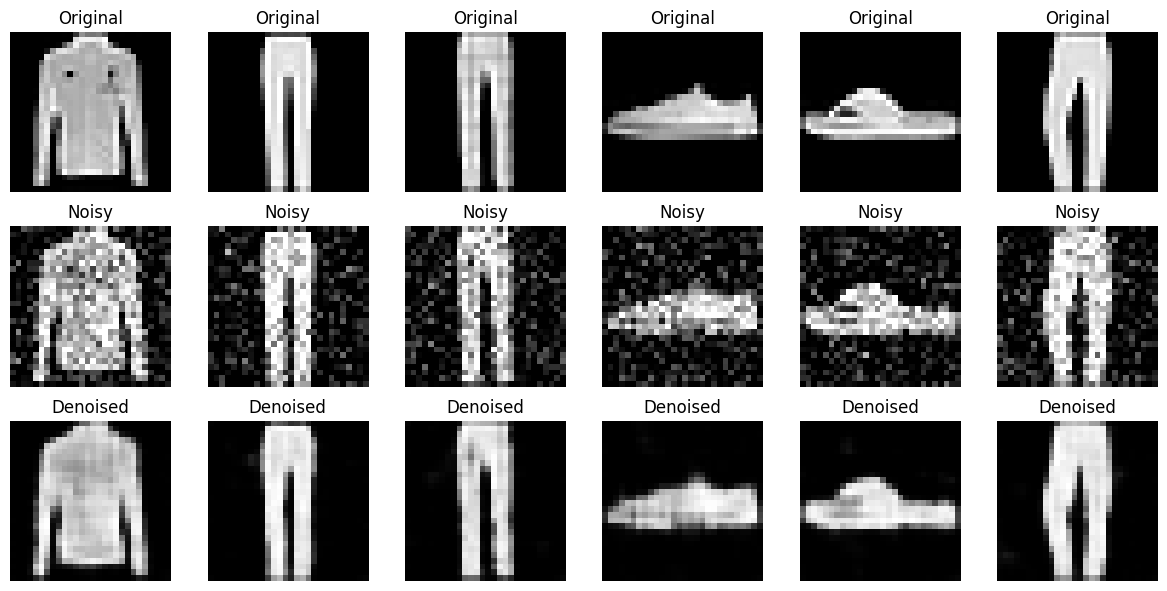

In [9]:
# Training loop
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, trainloader)
    test_loss = test(model, testloader)
    print(f'Epoch [{epoch}/{EPOCHS}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Visualize a few examples
dataiter = iter(testloader)
images, labels = next(dataiter)
noisy_images = add_noise(images)
outputs = model(noisy_images)

# Plot original, noisy, and denoised images
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for i in range(6):
    # Original images
    axes[0, i].imshow(images[i].squeeze().numpy(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Noisy images
    axes[1, i].imshow(noisy_images[i].squeeze().numpy(), cmap='gray')
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')
    
    # Denoised images
    axes[2, i].imshow(outputs[i].squeeze().detach().numpy(), cmap='gray')
    axes[2, i].set_title("Denoised")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Save the model to 1_model/
torch.save(model.state_dict(), '1_model/denoise_unet_140_f32.pth', _use_new_zipfile_serialization=False )

In [12]:
# Save the onnx model as well
dummy_input = torch.randn(1, 1, 28, 28, dtype=torch.float32)
torch.onnx.export(model, dummy_input, '1_model/denoise_unet_140_f32.onnx', 
                  input_names=['input'], output_names=['output'], 
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
# Save the model to 1_model/ in ONNX format
print("Model saved to 1_model/denoise_unet_140_f32.pth and 1_model/denoise_unet_140_f32.onnx")

Model saved to 1_model/denoise_unet_140_f32.pth and 1_model/denoise_unet_140_f32.onnx
